<a href="https://colab.research.google.com/github/yuanyuan233333/Bayesian-statistics/blob/main/TA13_SpatioTemporalModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spatio-Temporal Models is Stan

Modelling spatio-temporal data in Bayesian statistics can be done by assuming the following model for a observations $Y(\mathbf{s}, t)$ observed at location $\mathbf{s}$ and at time $t$:

\begin{equation*}
    Y(\mathbf{s}, t) = \mathbf{X}(\mathbf{s}, t)^{T}\boldsymbol{\beta}(\mathbf{s}, t) + \mathbf{w}(\mathbf{s}, t) + \epsilon(\mathbf{s}, t),
\end{equation*}

where:

- $\mathbf{X}(\mathbf{s}, t)^{T}\boldsymbol{\beta}(\mathbf{s}, t)$ is the component that takes into account possible spatio-temporal covariates and regressors. According to the given covariates, simplified version of this regressive part are often considered;
- $\mathbf{w}(\mathbf{s}, t)$ is a spatio-temporal process. it can take several forms, according to the modelling assumptions;
- $\epsilon(\mathbf{s}, t)$ is a generic spatio-temporal white noise.

In today's class, we will consider a way more simpler example:

## Monthy temperatures in Colorado
We consider a dataset taken from [Banerjee, Carlin \& Gelfand (2003)][1] about montly temperatures in Colorado.

[1]: https://www.taylorfrancis.com/books/mono/10.1201/9780203487808/hierarchical-modeling-analysis-spatial-data-sudipto-banerjee-sudipto-banerjee-bradley-carlin-alan-gelfand

In [1]:
!pip list | grep cmdstanpy
!pip list | grep arviz
# Install cmdstan -- Just for the first time!
from cmdstanpy import install_cmdstan
install_cmdstan()

cmdstanpy                          1.2.5
arviz                              0.20.0
CmdStan install directory: /root/.cmdstan
Installing CmdStan version: 2.36.0
Download successful, file: /tmp/tmpgkmz_kss
Extracting distribution


DEBUG:cmdstanpy:cmd: make build -j1
cwd: None


Unpacked download as cmdstan-2.36.0
Building version cmdstan-2.36.0, may take several minutes, depending on your system.


DEBUG:cmdstanpy:cmd: make examples/bernoulli/bernoulli
cwd: None


Installed cmdstan-2.36.0
Test model compilation


True

In [2]:
# Required modules
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# Required functions
from cmdstanpy import CmdStanModel

# Create ./stan folder if does not exists
if not os.path.exists("./stan"):
    os.mkdir("./stan")

In [3]:
# Import dataset
df = pd.read_csv("colorado_spatio-temporal.csv", sep=" ", index_col=0)
df.head(5)

,Lon,Lat,X,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
1,-109.330,37.870,2.156,0.07,0.22,1.08,1.14,2.08,2.53,2.83,2.61,2.27,1.53,0.78,0.14
2,-107.650,37.380,2.464,0.25,0.51,1.15,1.00,1.75,2.24,2.55,2.39,2.18,1.54,0.82,0.38
3,-106.657,36.956,2.561,0.02,0.36,1.20,1.01,1.71,2.27,2.56,2.37,2.15,1.37,0.66,0.18
4,-108.080,40.520,1.806,-0.02,0.25,1.10,1.18,2.14,2.71,2.96,2.84,2.34,1.64,0.68,0.04
5,-106.969,40.848,2.652,-0.22,0.07,0.68,0.67,1.43,2.01,2.29,2.13,1.73,1.03,0.19,-0.04


$\newcommand{\iid}{\stackrel{\tiny\mbox{iid}}{\sim}}$

We consider a separable spatio-temporal process, so that the spatial and temporal part can be modelled independently. We assume a 2D Gaussian Process in space and a AR(1) process in time. Hence, let $\mathbf{Y}_{t} = (Y(\mathbf{s}_1, t), \dots, Y(\mathbf{s}_1, t)) \in \mathbb{R}^{N}$, and define $\mathbf{Y} = (\mathbf{Y}_1,\dots,\mathbf{Y}_T) \in \mathbb{R}^{N \times T}$.

We specify the Bayesian model as:

\begin{align*}
    \mathbf{Y} \mid \boldsymbol{\beta}, \boldsymbol{\alpha}, \mathbf{w}, \tau^2 &\sim \mathcal{N}(\mathbf{1}_{T \times 1} \otimes (\mathbf{X}\boldsymbol{\beta} + \mathbf{w}) + \boldsymbol{\alpha} \otimes \mathbf{1}_{N \times 1}, \tau^2\mathbf{I}_{TN \times TN}) \\
    \beta_{p} &\iid \mathcal{N}(0, 5) \quad p=1,\dots,P \\
    \boldsymbol{\alpha} \mid \sigma_{\alpha}^2 &\sim \mathcal{N}(\mathbf{0}, \sigma_{\alpha}^2 \mathbf{A}(\rho)) \\
    \mathbf{w} \mid \sigma_{w}^2 &\sim \mathcal{N}(\mathbf{0}, \sigma_{w}^2\mathbf{H}(\phi)) \\
    \sigma_{\alpha}, \sigma_{w}, \tau &\iid \mathcal{HC}(0, 1)
\end{align*}

With matrices defined as follows:

\begin{align*}
    \mathbf{A}(\rho)_{ij} &= \frac{1}{(1-\rho^2)} \rho^{\lvert i-j \rvert} \\[5pt]
    \mathbf{H}(\phi)_{ij} &= \exp\{-\phi\lvert \mathbf{s}_{i} - \mathbf{s}_{j} \rvert\}
\end{align*}

In [4]:
# Set problem size
NSITES = 50
NTIME = 12
P = 1

In [5]:
# Useful functions for the spatio-temporal model
spt_tools = \
"""
// Computes Spatial covariance kernel
matrix cov_exp(matrix coords, real phi) {
    int N = dims(coords)[1];
    matrix[N,N] dist;
    for (i in 1:N) {
        for(j in i:N) {
            dist[i,j] = distance(coords[i], coords[j]);
            dist[j,i] = dist[i,j];
        }
    }
    return exp(-phi * dist);
}

// Computes Temporal covariance kernel
matrix cov_time(int T, real rho_t) {
    matrix[T,T] cov;
    for (i in 1:T) {
        for(j in i:T) {
            cov[i,j] = rho_t^abs(i-j);
            cov[j,i] = cov[i,j];
        }
    }
    return (1/(1-rho_t^2)) * cov;
}

// Computes kronecker product between vectors
vector kron_prod(vector A, vector B){
    int N = size(A);
    int P = size(B);
    vector[N*P] kron;
    for (i in 1:N) {
        kron[((i-1)*P+1):i*P] = A[i] * B;
    }
    return kron;
}
"""

# Write functions to file
stan_file = "stan/spt-tools.stan"
with open(stan_file, "w") as f:
    print(spt_tools, file=f)

In [6]:
# GP-AR Spatio-Temporal Model with Stan
spt_lm = \
"""
functions {
    #include "spt-tools.stan"
}

data {
    int<lower=1> N;     // number of data points
    int<lower=1> T;     // number of time intervals
    int<lower=0> P;     // number of predictors
    matrix[N,T] Y;      // data
    matrix[N,P] X;      // matrix of predictors
    matrix[N,2] coords; // coordinates
    real<lower=0> phi;  // spatial range
    real<lower=0> rho;  // time innovation coefficient
}

transformed data {
    // Spatial covariance matrix
    matrix[N,N] H = cov_exp(coords, phi);

    // Temporal covariance matrix
    matrix[T,T] Ht = cov_time(T, rho);

    // Data vectorized
    vector[N*T] Y_vect = to_vector(Y);
}

parameters {
    vector[N] w;              // spatial process
    vector[T] alpha;          // temporal process
    vector[P] beta;           // predictor vectors
    real<lower=0> sigmas;     // spatial std. dev.
    real<lower=0> sigmat;     // temporal std. dev.
    real<lower=0> tau;        // linear std. dev.
}

transformed parameters {
    // Mean vector
    vector[N*T] mu = kron_prod(rep_vector(1,T), (X * beta + w)) + kron_prod(alpha, rep_vector(1,N));

    // Spatial Covariance Matrix
    matrix[N,N] Sigma_s = sigmas * sigmas * H;
    matrix[N,N] Lw = cholesky_decompose(Sigma_s);

    // Temporal Covariance Matrix
    matrix[T,T] Sigma_t = sigmat * sigmat * Ht;
    matrix[T,T] Lalpha = cholesky_decompose(Sigma_t);
}

model {
    // Likelihood
    Y_vect[1:N*T] ~ normal(mu[1:N*T], tau);

    // Prior
    w ~ multi_normal_cholesky(rep_vector(0,N), Lw);
    alpha ~ multi_normal_cholesky(rep_vector(0,T), Lalpha);
    beta ~ normal(0,5);
    sigmas ~ cauchy(0,1);
    sigmat ~ cauchy(0,1);
    tau ~ cauchy(0,1);
}
"""

# Write model to file
stan_file = "stan/spt_lm.stan"
with open(stan_file, "w") as f:
    print(spt_lm, file=f)

# Compile model
spt_lm = CmdStanModel(stan_file=stan_file)

00:28:24 - cmdstanpy - INFO - compiling stan file /content/stan/spt_lm.stan to exe file /content/stan/spt_lm
INFO:cmdstanpy:compiling stan file /content/stan/spt_lm.stan to exe file /content/stan/spt_lm
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=spt_lm.stan STANCFLAGS+=--include-paths=/content/stan /content/stan/spt_lm
cwd: /root/.cmdstan/cmdstan-2.36.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=spt_lm.stan --include-paths=/content/stan --o=/content/stan/spt_lm.hpp /content/stan/spt_lm.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.84.0 -I stan/lib/stan_math/lib/sundials_6.1.1/include -I stan/lib/stan_math/lib/su

We now prepare the data dictionary

In [7]:
Y = df.iloc[:, 3:15].values
Y.shape

(50, 12)

In [8]:
X = np.array([df["X"].values - np.mean(df["X"].values)]).transpose()
X.shape

(50, 1)

In [9]:
coords = df.iloc[:,0:2].values
coords.shape

(50, 2)

In [10]:
# Create data dictionary for Stan
spt_lm_data = {
    "N": NSITES,
    "T": NTIME,
    "P": P,
    "Y": Y,
    "X": X,
    "coords": coords,
    "phi": 1.09,
    "rho": 0.9
}

# Fit model via Stan
spt_lm_fit = spt_lm.sample(data=spt_lm_data, chains=4, parallel_chains=4, iter_sampling=2000)

DEBUG:cmdstanpy:cmd: /content/stan/spt_lm info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9_lhauyj/0chz18mb.json
00:35:12 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/spt_lm', 'id=1', 'random', 'seed=35121', 'data', 'file=/tmp/tmp9_lhauyj/0chz18mb.json', 'output', 'file=/tmp/tmp9_lhauyj/spt_lmkdv1n9za/spt_lm-20250209003512_1.csv', 'method=sample', 'num_samples=2000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/spt_lm', 'id=2', 'random', 'seed=35121', 'data', 'file=/tmp/tmp9_lhauyj/0chz18mb.json', 'output', 'file=/tmp/tmp9_lhauyj/spt_lmkdv1n9za/spt_lm-20250209003512_2.csv', 'method=sample', 'num_samples=2000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/spt_lm', 'id=3', 'random', 'seed=35121', 'data', 'file=/tmp/tmp9_lhauyj/0chz18mb.json', 'output', 'file=/tmp/tmp9_lhauyj/spt_lmkdv1n9za/spt_lm-20250209003512_3.csv', 'm

00:36:33 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/stan/spt_lm', 'id=1', 'random', 'seed=35121', 'data', 'file=/tmp/tmp9_lhauyj/0chz18mb.json', 'output', 'file=/tmp/tmp9_lhauyj/spt_lmkdv1n9za/spt_lm-20250209003512_1.csv', 'method=sample', 'num_samples=2000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp9_lhauyj/spt_lmkdv1n9za/spt_lm-20250209003512_1.csv
 console_msgs (if any):
	/tmp/tmp9_lhauyj/spt_lmkdv1n9za/spt_lm-20250209003512_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 2000
    num_warmup = 1000 (Default)
    save_warmup = false (Default)
    thin = 1 (Default)
    adapt
      engaged = true (Default)
      gamma = 0.05 (Default)
      delta = 0.8 (Default)
      kappa = 0.75 (Default)
      t

In [11]:
# Convert to arviz datatype
spt_lm_az = az.from_cmdstanpy(spt_lm_fit)

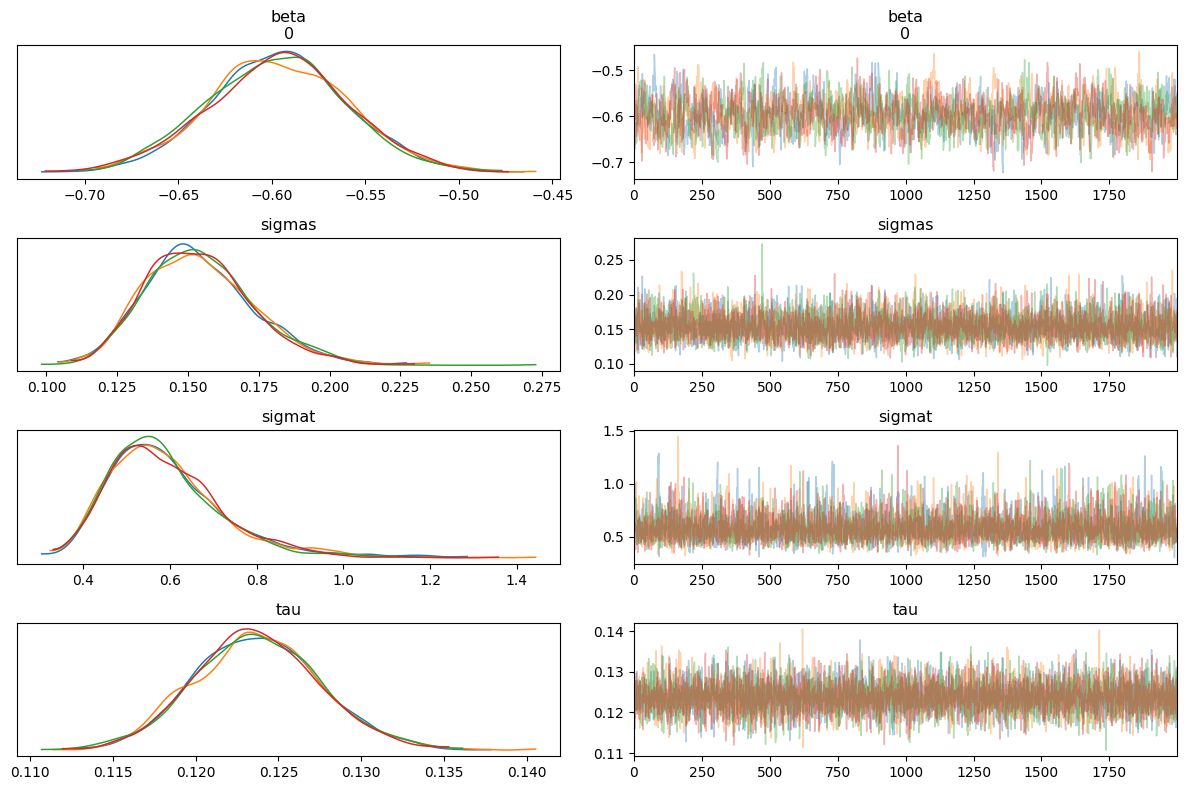

In [12]:
# Traceplots of parameters
az.plot_trace(spt_lm_az, var_names=["beta","sigmas","sigmat","tau"], compact=False)
plt.tight_layout()
plt.show()

### Homework
Let's learn the spatio-temporal process! Try to set proper priors to the parameters that defines the spatial and temporal covariance function, i.e., $\phi$ and $\rho$.

**Remark**: While dealing with spatio-temporal data, remember that parameters involved in the covariance function ($\phi$ for the spatial process and $\rho$ for the temporal process) are non-identifiable. This non-identifiability is general to this type of models and may worse the quality of the sampling. The simplest solution is to fix those parameters or to set a more informative prior.

### Kriging in spatio-temporal models
$\newcommand{\dd}{\text{d}}$
In spatial statistics, _kriging_ is one of several methods that use a limited set of sampled data points to estimate the value of a variable over a continuous spatial field. In the Bayesian approach, this is nothing more than computing a posterior predictive distribution! In fact, if we want to estimate the value $y^* = y(\mathbf{s^*}, t)$ in a new location $\mathbf{s}^*$ for a given time $t$. Then, we just need to compute

$$
\pi(y^{*} \mid \mathbf{Y}) = \int \mathcal{L} \left(y^* \mid w^*, \boldsymbol{\beta}, \boldsymbol{\alpha}, \tau^2 \right) \cdot \pi\left( \dd w^* \mid \mathbf{w}, \sigma^2_w\right) \cdot \pi\left( \dd\boldsymbol{\beta}, \dd\boldsymbol{\alpha}, \dd\mathbf{w}, \dd\sigma^2_w, \dd\tau^2 \mid \mathbf{Y}\right), \tag{1}
$$
where $w^*$ is the spatial process in the new location $\mathbf{s}^*$. Now, call $\Sigma_{\mathbf{w}}(\phi) = \sigma^2_{w} \mathbf{H}(\phi)$. Then:

$$
\begin{eqnarray}
    \mathcal{L} \left(y^* \mid w^*, \boldsymbol{\beta}, \boldsymbol{\alpha}, \tau^2 \right) &=& \mathcal{N}\left(y^* \mid \mathbf{x}^{*T}\boldsymbol{\beta} + \alpha_t + w^*, \tau^2\right), \tag{2}\\
    \pi\left(w^* \mid \mathbf{w}, \sigma^2_w\right) &=& \mathcal{N}\left(w^* \mid \Sigma_{\mathbf{w}, w^*}^T \Sigma_{\mathbf{w}}^{-1}\mathbf{\mathbf{w}}, \Sigma_{w*} - \Sigma_{\mathbf{w}, w^*}^T \Sigma_{\mathbf{w}}^{-1}\Sigma_{\mathbf{w}, w^*} \right), \tag{3}\\
\end{eqnarray}
$$
where $\Sigma_{\mathbf{w}, w^*}$ is an $N \times 1$ matrix with elements $[\Sigma_{\mathbf{w}, w^*}]_{i1} = \sigma^2_w \exp\{-\phi\lvert\mathbf{s}_i - \mathbf{s}^*\rvert\}$. A similar computation can be done also in case of multiple prediction locations. Finally, we collect posterior draws for $\left(\boldsymbol{\beta}, \boldsymbol{\alpha}, \mathbf{w}, \sigma^2_w, \tau^2\right)$ from the MCMC. Hence, Kriging can be performed as follows:
1. Sample $w^*$ from (3) after each posterior draws of $\left(\boldsymbol{\beta}, \boldsymbol{\alpha}, \mathbf{w}, \sigma^2_w, \tau^2\right)$;
2. Sample $y^*$ given $w^*$ and the posterior draws from (2);
3. Approximate (1) via Monte Carlo integration

In [13]:
spt_pred_tools = \
"""
// Computes spatial covariance kernel between observed and predicted coordinates
matrix cov_exp2(matrix coords1, matrix coords2, real phi) {
    int N1 = dims(coords1)[1];
    int N2 = dims(coords2)[1];
    matrix[N1,N2] dist;
    for (i in 1:N1) {
        for(j in 1:N2) {
            dist[i,j] = distance(coords1[i], coords2[j]);
        }
    }
    return exp(-phi * dist);
}

// Generates random sample from the posterior predictive distribution of a Gaussian Process
vector gp_pred_rng(vector W, matrix coords, matrix coords_pred, real sigma_sq, real phi) {

    // Setting dimensions
    int N1 = dims(coords)[1];
    int N2 = dims(coords_pred)[1];

    // Compute Covariance matrices
    matrix[N1,N1] Sigma11 = sigma_sq * cov_exp(coords, phi);
    matrix[N2,N2] Sigma22 = sigma_sq * cov_exp(coords_pred, phi);
    matrix[N1,N2] Sigma12 = sigma_sq * cov_exp2(coords, coords_pred, phi);

    // Buffers for output
    vector[N2] mu_pred;
    matrix[N2,N2] cov_pred;
    vector[N2] W_pred;

    // Helpers
    matrix[N1,N1] Sigma11_L;
    vector[N1] Sigma11_inv_W;
    matrix[N1,N2] L_inv_Sigma12;

    // Conditional mean
    Sigma11_L = cholesky_decompose(Sigma11);
    Sigma11_inv_W = mdivide_left_tri_low(Sigma11_L, W);
    Sigma11_inv_W = mdivide_right_tri_low(Sigma11_inv_W', Sigma11_L)';
    mu_pred = Sigma12' * Sigma11_inv_W;

    // Conditional covariance
    L_inv_Sigma12 = mdivide_left_tri_low(Sigma11_L, Sigma12);
    cov_pred = Sigma22 - L_inv_Sigma12' * L_inv_Sigma12;

    // Sample from posterior predictive distribution
    W_pred = multi_normal_rng(mu_pred, cov_pred);
    return W_pred;
}

"""

# Write functions to file
stan_file = "stan/spt_pred-tools.stan"
with open(stan_file, "w") as f:
    print(spt_pred_tools, file=f)

Notice the algebra behind the computation of conditional mean and variance of the Gaussian Process. The main idea is: _it is more efficient to invert a lower-triangular matrix w.r.t. a full matrix_. Hence, we rely on some algebra involving matrix operation and Cholesky factorization that relies only on inversion of lower triangular matrices.

Let $\mathbf{L}$ be the Cholesky factorization of $\Sigma_{\mathbf{w}}$. Then:
$$
    \begin{eqnarray}
        \Sigma_{\mathbf{w}, w^*}^T \Sigma_{\mathbf{w}}^{-1}\mathbf{\mathbf{w}} &=& \Sigma_{\mathbf{w}, w^*}^T \left(\mathbf{L}\mathbf{L}^T\right)^{-1}\mathbf{w} = \Sigma_{\mathbf{w}, w^*}^T\mathbf{L}^{-T}\mathbf{L}^{-1}\mathbf{w} = \Sigma_{\mathbf{w}, w^*}^T\left[\left(\mathbf{L}^{-1}\mathbf{w}\right)^{T}\mathbf{L}^{-1}\right]^{T}; \\
        \Sigma_{w*} - \Sigma_{\mathbf{w}, w^*}^T \Sigma_{\mathbf{w}}^{-1}\Sigma_{\mathbf{w}, w^*} &=& \Sigma_{w*} - \Sigma_{\mathbf{w}, w^*}^T \left(\mathbf{L}\mathbf{L}^{T}\right)^{-1}\Sigma_{\mathbf{w}, w^*} = \Sigma_{w*} - \Sigma_{\mathbf{w}, w^*}^T \mathbf{L}^{-T}\mathbf{L}^{-1}\Sigma_{\mathbf{w}, w^*} = \Sigma_{w*} - \left[\mathbf{L}^{-1}\Sigma_{\mathbf{w}, w^*}\right]^{T}\left[\mathbf{L}^{-1}\Sigma_{\mathbf{w}, w^*}\right].
    \end{eqnarray}
$$

In [14]:
# GP-AR Spatio-Temporal Model (+ Kriging) in Stan
spt_lm_pred = \
"""
functions {
    #include "spt-tools.stan"
    #include "spt_pred-tools.stan"
}

data {
    int<lower=1> N;               // number of data points
    int<lower=1> T;               // number of time intervals
    int<lower=0> P;               // number of predictors
    matrix[N,T] Y;                // data
    matrix[N,P] X;                // matrix of predictors
    matrix[N,2] coords;           // points coordinates
    real<lower=0> phi;            // spatial range
    real<lower=0> rho;            // time innovation coefficient
    int<lower=1> N_pred;          // number of data to predict
    matrix[N_pred,P] X_pred;      // matrix of predictors to pred
    matrix[N_pred,2] pred_coords; // coordinates of points to predict
    int<lower=1, upper=12> time;  // prediction time
}

transformed data {
    // Spatial covariance matrix
    matrix[N,N] H = cov_exp(coords, phi);

    // Temporal covariance matrix
    matrix[T,T] Ht = cov_time(T, rho);

    // Data vectorized
    vector[N*T] Y_vect = to_vector(Y);
}

parameters {
    vector[N] w;              // spatial process
    vector[T] alpha;          // temporal process
    vector[P] beta;           // predictor vectors
    real<lower=0> sigmas;     // spatial std. dev.
    real<lower=0> sigmat;     // temporal std. dev.
    real<lower=0> tau;        // linear std. dev.
}

transformed parameters {
    // Mean vector
    vector[N*T] mu = kron_prod(rep_vector(1,T), X * beta + w) + kron_prod(alpha, rep_vector(1,N));

    // Spatial Covariance Matrix
    matrix[N,N] Sigma_s = sigmas * sigmas * H;
    matrix[N,N] Lw = cholesky_decompose(Sigma_s);

    // Temporal Covariance Matrix
    matrix[T,T] Sigma_t = sigmat * sigmat * Ht;
    matrix[T,T] Lalpha = cholesky_decompose(Sigma_t);
}

model {
    // Likelihood
    Y_vect[1:N*T] ~ normal(mu[1:N*T], tau);

    // Prior
    w ~ multi_normal_cholesky(rep_vector(0,N), Lw);
    alpha ~ multi_normal_cholesky(rep_vector(0,T), Lalpha);
    beta ~ normal(0,5);
    sigmas ~ cauchy(0,1);
    sigmat ~ cauchy(0,1);
    tau ~ cauchy(0,1);
}

generated quantities {
    // Kriging
    array[N_pred] real Y_kriged;
    vector[N_pred] w_pred = gp_pred_rng(w, coords, pred_coords, (sigmas * sigmas), phi);
    vector[N_pred] mean_pred = X_pred * beta + w_pred + rep_vector(alpha[time], N_pred);
    Y_kriged[1:N_pred] = normal_rng(mean_pred[1:N_pred], tau);
}
"""

# Write model to file
stan_file = "stan/spt_lm_pred.stan"
with open(stan_file, "w") as f:
    print(spt_lm_pred, file=f)

# Compile model
spt_lm_pred = CmdStanModel(stan_file=stan_file)

00:57:05 - cmdstanpy - INFO - compiling stan file /content/stan/spt_lm_pred.stan to exe file /content/stan/spt_lm_pred
INFO:cmdstanpy:compiling stan file /content/stan/spt_lm_pred.stan to exe file /content/stan/spt_lm_pred
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=spt_lm_pred.stan STANCFLAGS+=--include-paths=/content/stan /content/stan/spt_lm_pred
cwd: /root/.cmdstan/cmdstan-2.36.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=spt_lm_pred.stan --include-paths=/content/stan --o=/content/stan/spt_lm_pred.hpp /content/stan/spt_lm_pred.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.84.0 -I stan/lib/stan_math/lib/sundia

In [15]:
# Compute prediction box
x_min, y_min = np.min(coords, axis=0)
x_max, y_max = np.max(coords, axis=0)

# Compute prediction coordinates
x = np.linspace(x_min, x_max, num = 25)
y = np.linspace(y_min, y_max, num = 25)
coords_pred = np.dstack(np.meshgrid(x, y)).reshape(-1, 2)
coords_pred.shape

(625, 2)

In [16]:
# Prediction covariates matrix
X_pred = X[24,0] * np.ones(shape=(coords_pred.shape[0], 1))
X_pred.shape

(625, 1)

In [17]:
# Prediction month
month = 1

In [18]:
# Create data dictionary for Stan
spt_lm_pred_data = {
    "N": NSITES,
    "T": NTIME,
    "P": P,
    "Y": Y,
    "X": X,
    "coords": coords,
    "phi": 1.09,
    "rho": 0.9,
    "N_pred": coords_pred.shape[0],
    "X_pred": X_pred,
    "pred_coords": coords_pred,
    "time": month
}

# Fit model via Stan
spt_lm_pred_fit = spt_lm_pred.sample(data=spt_lm_pred_data, chains=4, parallel_chains=4, iter_sampling=2000)

DEBUG:cmdstanpy:cmd: /content/stan/spt_lm_pred info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9_lhauyj/86fih3t_.json
01:01:08 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/spt_lm_pred', 'id=1', 'random', 'seed=17324', 'data', 'file=/tmp/tmp9_lhauyj/86fih3t_.json', 'output', 'file=/tmp/tmp9_lhauyj/spt_lm_preduh4vtsp9/spt_lm_pred-20250209010108_1.csv', 'method=sample', 'num_samples=2000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/spt_lm_pred', 'id=2', 'random', 'seed=17324', 'data', 'file=/tmp/tmp9_lhauyj/86fih3t_.json', 'output', 'file=/tmp/tmp9_lhauyj/spt_lm_preduh4vtsp9/spt_lm_pred-20250209010108_2.csv', 'method=sample', 'num_samples=2000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:idx 3
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/spt_lm_pred', 'id=3', 'random', 'seed=17324', 'data', 'file=/tmp/tmp9_lhauyj/86fih3t_.json', 'output', 'file=/tmp/tm

01:07:22 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/stan/spt_lm_pred', 'id=1', 'random', 'seed=17324', 'data', 'file=/tmp/tmp9_lhauyj/86fih3t_.json', 'output', 'file=/tmp/tmp9_lhauyj/spt_lm_preduh4vtsp9/spt_lm_pred-20250209010108_1.csv', 'method=sample', 'num_samples=2000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp9_lhauyj/spt_lm_preduh4vtsp9/spt_lm_pred-20250209010108_1.csv
 console_msgs (if any):
	/tmp/tmp9_lhauyj/spt_lm_preduh4vtsp9/spt_lm_pred-20250209010108_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 2000
    num_warmup = 1000 (Default)
    save_warmup = false (Default)
    thin = 1 (Default)
    adapt
      engaged = true (Default)
      gamma = 0.05 (Default)
      delta = 0.8 (Default)
 

In [19]:
# Convert to arviz datatype
spt_lm_pred_az = az.from_cmdstanpy(spt_lm_pred_fit)

In [20]:
# Getting chain of kriged observations
Y_kriged_chain = np.vstack(spt_lm_pred_az.posterior.Y_kriged)

# Compute posterior mean and variance
Y_kriged_mean = np.mean(Y_kriged_chain, axis=0)
Y_kriged_var = np.var(Y_kriged_chain, axis=0)

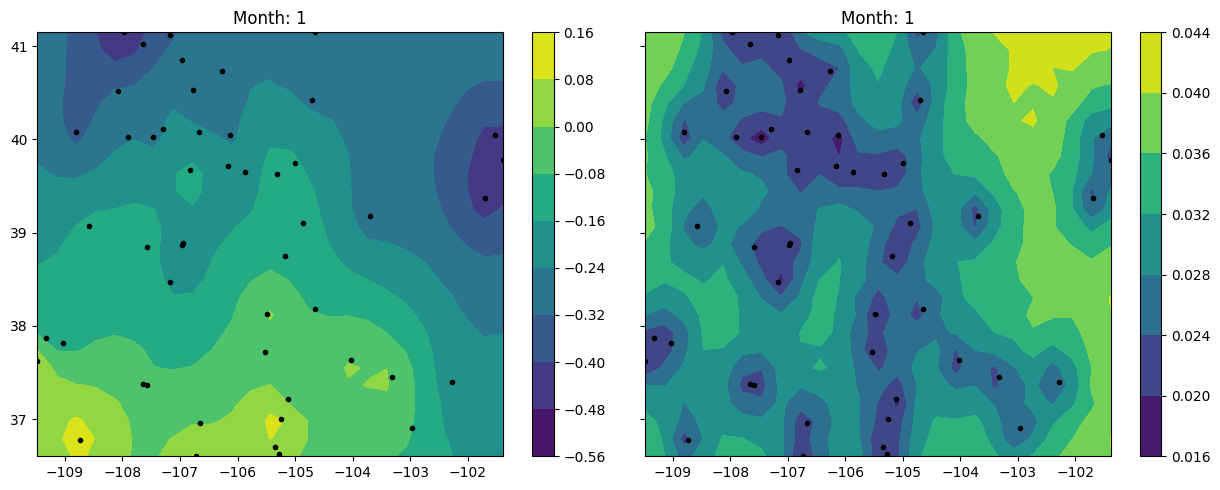

In [21]:
# Taking only observations in given month
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12.5,5))

# Grid of points for contour
xr, yr = np.meshgrid(x,y)

# Month contour plots (mean and variance)
CS_mean = axes[0].contourf(xr, yr, Y_kriged_mean.reshape(x.size,y.size))
axes[0].plot(coords[:,0], coords[:,1], '.', color = 'black')
axes[0].set_title("Month: {0}".format(month))
CS_var = axes[1].contourf(xr, yr, Y_kriged_var.reshape(x.size,y.size))
axes[1].plot(coords[:,0], coords[:,1], '.', color = 'black')
axes[1].set_title("Month: {0}".format(month))

# Add colorbars
fig.colorbar(CS_mean)
fig.colorbar(CS_var)

# Show plot
plt.tight_layout()
plt.show()

### Homework: Forecasts in spatio-temporal models
While dealing with time series models, _forecasting_ is the procedure that predicts a future value of the observed variable, given the observed tred.

1. Rephrase the problem in terms of predictive distributions;
2. Adapt the previous code to produce a one-month forecasting;
3. Consider the time series from January to November and try to forecast the log-standardized temperature in December with the implemented code. Compare the posterior predictive mean with the true data.